<a href="https://colab.research.google.com/github/yamasaki-yu/learning/blob/master/TimeSeriesAnalysis_LSTMtutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNNお試し<br>
参考<br>
https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf<br> 

In [34]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd

# グラフ描画
from matplotlib import pylab as plt
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


データセットの読み込み

In [35]:
# データの読み込み
filepath = 'drive/My Drive/Colab Notebooks/TimeSeriesAnalysis_tutorial/AirPassengers.csv'
data = pd.read_csv(filepath)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


データの概観確認

In [36]:
# 列名の変更
data.columns = ["Month", "Passengers"]

#概観の確認
print("Missing data:")
print("  Month : " ,data["Month"].isnull().sum())
print("  Passengers : " ,data["Passengers"].isnull().sum())
data.describe()

Missing data:
  Month :  0
  Passengers :  0


,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


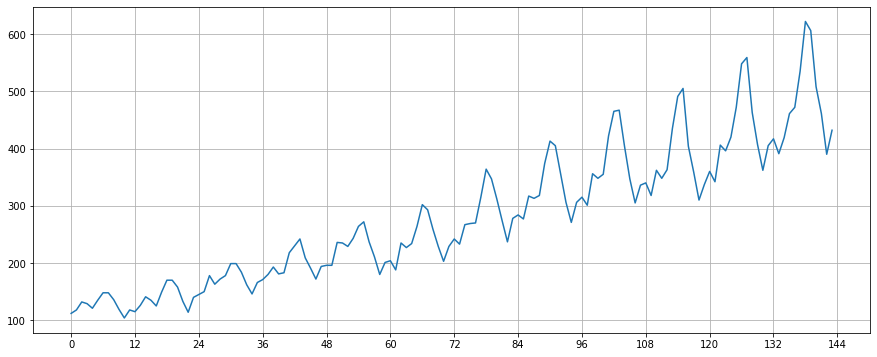

In [37]:
# データのプロット
plt.plot(data["Passengers"])
plt.xticks(np.arange(0, 145, 12)) # 12ヶ月ごとにグリッド線を表示
plt.grid()
plt.show()

前処理

In [38]:
# Kerasに入力するための型へ変換
input_data = data['Passengers'].values.astype(float)
print("input_data : " , input_data.shape ,type(input_data))

# スケールの正規化
norm_scale = input_data.max()
input_data /= norm_scale
print(input_data[0:5])

input_data :  (144,) <class 'numpy.ndarray'>
[0.18006431 0.18971061 0.21221865 0.2073955  0.19453376]


In [45]:
# 入力データと教師データの作成
def make_dataset(low_data, maxlen):

    data, target = [], []

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target


# RNNへの入力データ数
window_size = 12

# 入力データと教師データへの分割
X, y = make_dataset(input_data, window_size)
print("shape X : " , X.shape)
print("shape y: " , y.shape)

shape X :  (132, 12, 1)
shape y:  (132, 1)


In [40]:
# 学習データ / 検証データ分割

split_rate = 0.7 # 学習データの割合
train_size = int(len(X) * split_rate)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(" train_size / test_size = ", train_size , "/" , len(X) - train_size)
print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)

 train_size / test_size =  92 / 40
X_train: (92, 12, 1)
X_test : (40, 12, 1)
y_train: (92, 1)
y_test : (40, 1)


LSTMモデル構築

In [41]:
# ライブラリのインポート
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import Adam
import tensorflow as tf

# ネットワークの構築
lstm_model = Sequential() # Sequentialモデル
lstm_model.add(LSTM(50, batch_input_shape=(None, window_size, 1))) # LSTM 50層
lstm_model.add(Dense(1)) # 出力次元数は1

#コンパイル
lstm_model.compile(loss='mean_squared_error', optimizer=Adam() , metrics = ['accuracy'])
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


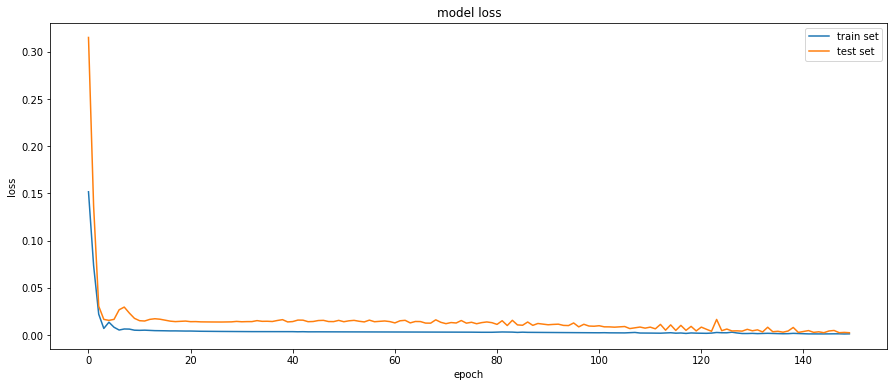

In [42]:
# 学習用パラメータ
batch_size = 20
n_epoch = 150

# 学習
hist = lstm_model.fit(X_train, y_train,
                 epochs=n_epoch,
                 validation_data=(X_test, y_test),
                 verbose=0,
                 batch_size=batch_size)

# 損失値(Loss)の遷移のプロット
plt.plot(hist.history['loss'],label="train set")
plt.plot(hist.history['val_loss'],label="test set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

学習結果の可視化

RMSE Score
  train :  0.030219804426221682
  test :  0.04880182804815519


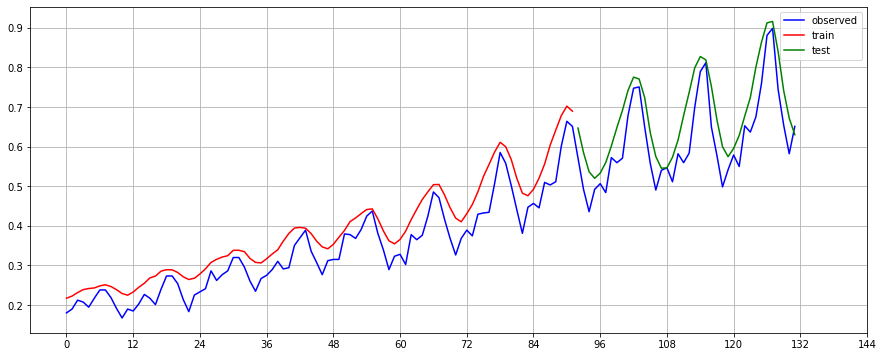

In [43]:
# 予測
y_pred_train = lstm_model.predict(X_train) 
y_pred_test = lstm_model.predict(X_test) 

# RMSEで評価
# 参考：https://deepage.net/deep_learning/2016/09/17/tflearn_rnn.html
def rmse(y_pred, y_true):
    return np.sqrt(((y_true - y_pred) ** 2).mean())
print("RMSE Score")
print("  train : " , rmse(y_pred_train, y_train))
print("  test : " , rmse(y_pred_test, y_test))

# 推定結果のプロット
plt.plot(X[:, 0, 0], color='blue',  label="observed")  # 元データ
plt.plot(y_pred_train, color='red',  label="train")   # 予測値（学習）
plt.plot(range(len(X_train),len(X_test)+len(X_train)),y_pred_test, color='green',  label="test")   # 予測値（検証）
plt.legend()
plt.xticks(np.arange(0, 145, 12)) # 12ヶ月ごとにグリッド線を表示
plt.grid()
plt.show()

未来予測

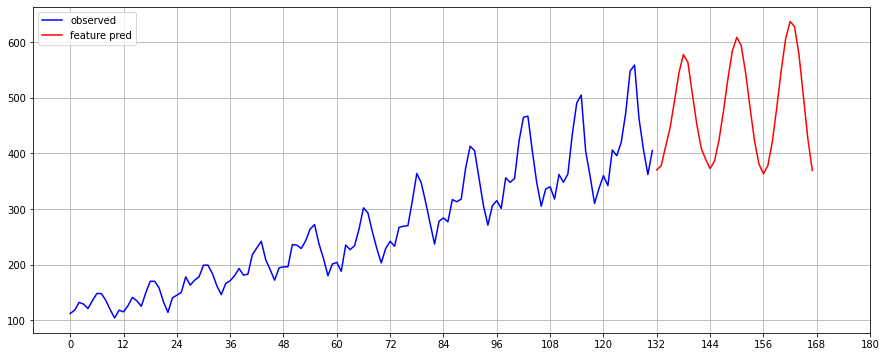

In [44]:
# 予測結果を保存する行列
future_pred = X[:,0,0].copy()

# 予測期間は観測値の終端から3年間を設定
pred_time_length = 12*3

for tmp in range(pred_time_length):
  # 観測結果の最後尾から予測に使うデータをピックアップ
  X_future_pred = future_pred[-1*window_size:]
  # 予測
  y_future_pred = lstm_model.predict( X_future_pred.reshape(1,window_size,1) )
  # 予測値をfuture_predの最後尾に追加
  future_pred = np.append(future_pred, y_future_pred)
  #print(y_future_pred ,  future_pred[-5:])

# プロット
plt.plot(X[:,0,0] * norm_scale, color='blue',  label="observed")  # 実測値
plt.plot(range(len(X),len(X)+pred_time_length), future_pred[-1*pred_time_length:] * norm_scale,  color='red',  label="feature pred")   # 予測値
plt.legend()
plt.xticks(np.arange(0, 145+pred_time_length, 12)) # 12ヶ月ごとにグリッド線を表示
plt.grid()
plt.show()
